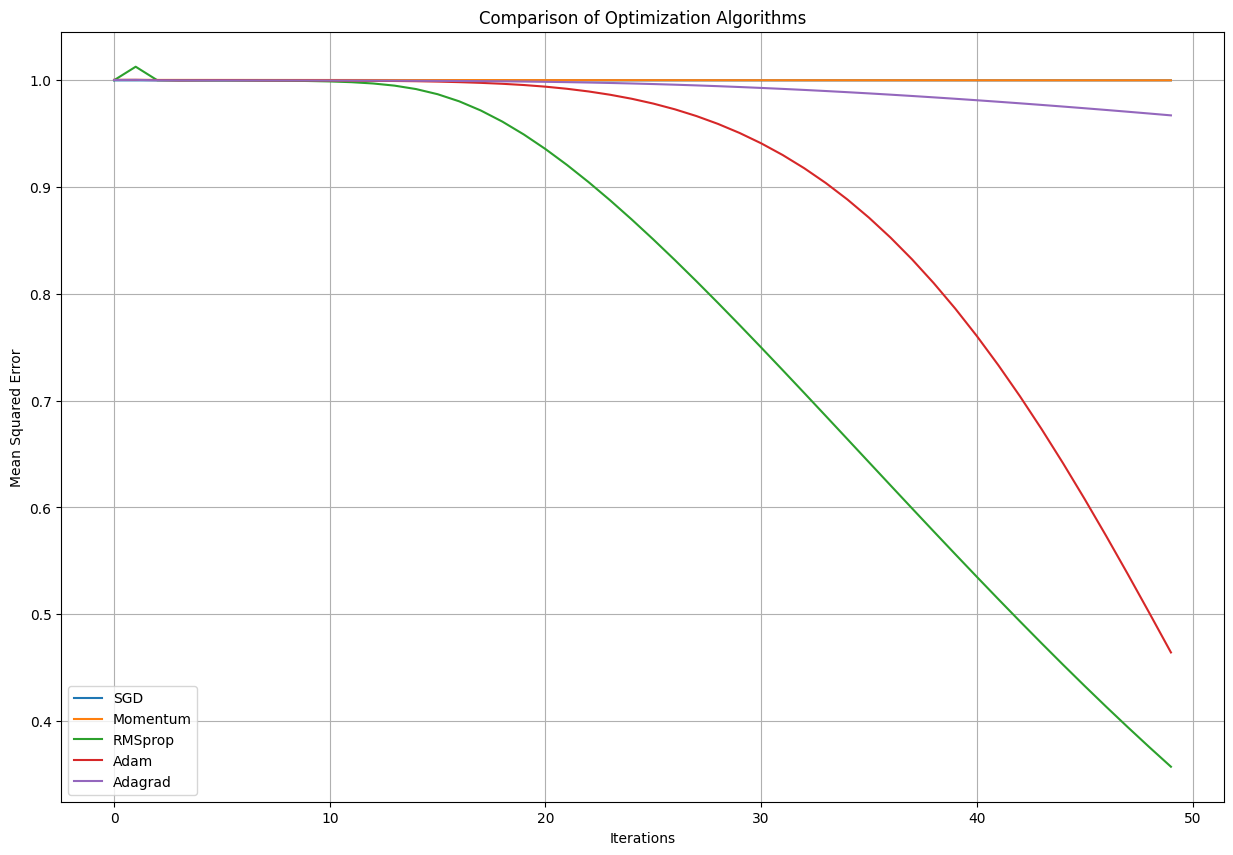

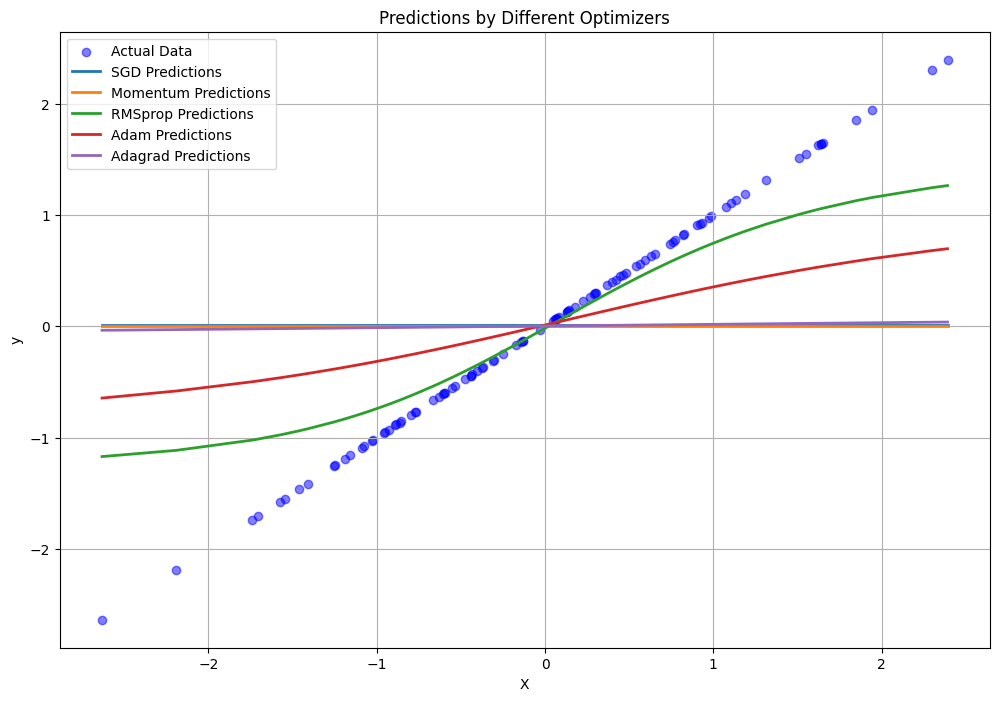

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow

def sigmoid_derivative(x):
    return x * (1 - x)

class MultiLayerPerceptron:
    def __init__(self, input_size=1, hidden1_size=8, hidden2_size=6, output_size=1, learning_rate=0.01, optimizer='SGD'):
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        
        # Initialize weights and biases
        self.w1 = np.random.randn(input_size, hidden1_size) * 0.01
        self.b1 = np.zeros((1, hidden1_size))
        self.w2 = np.random.randn(hidden1_size, hidden2_size) * 0.01
        self.b2 = np.zeros((1, hidden2_size))
        self.w3 = np.random.randn(hidden2_size, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))
        
        # Optimizer parameters
        # Momentum
        self.v_w1, self.v_b1 = np.zeros_like(self.w1), np.zeros_like(self.b1)
        self.v_w2, self.v_b2 = np.zeros_like(self.w2), np.zeros_like(self.b2)
        self.v_w3, self.v_b3 = np.zeros_like(self.w3), np.zeros_like(self.b3)
        self.beta = 0.9  # Momentum factor
        
        # RMSprop and Adam
        self.s_w1, self.s_b1 = np.zeros_like(self.w1), np.zeros_like(self.b1)
        self.s_w2, self.s_b2 = np.zeros_like(self.w2), np.zeros_like(self.b2)
        self.s_w3, self.s_b3 = np.zeros_like(self.w3), np.zeros_like(self.b3)
        self.beta2 = 0.999  # Adam factor
        
        # Adam specific
        self.m_w1, self.m_b1 = np.zeros_like(self.w1), np.zeros_like(self.b1)
        self.m_w2, self.m_b2 = np.zeros_like(self.w2), np.zeros_like(self.b2)
        self.m_w3, self.m_b3 = np.zeros_like(self.w3), np.zeros_like(self.b3)
        self.epsilon = 1e-8  # Small constant to prevent division by zero
        
        # Adagrad specific
        self.grad_sum_w1, self.grad_sum_b1 = np.zeros_like(self.w1), np.zeros_like(self.b1)
        self.grad_sum_w2, self.grad_sum_b2 = np.zeros_like(self.w2), np.zeros_like(self.b2)
        self.grad_sum_w3, self.grad_sum_b3 = np.zeros_like(self.w3), np.zeros_like(self.b3)
        
        # For tracking optimization trajectory
        self.w1_history = []
        self.w3_history = []
        self.loss_history = []
        self.t = 0  # Time step for Adam
        
    def forward(self, X):
        # Forward pass
        self.X = X
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.w3) + self.b3
        self.output = self.z3  # Linear output for regression
        return self.output
    
    def backward(self, y):
        m = self.X.shape[0]
        
        # Output layer
        d_output = (self.output - y) / m  # MSE derivative
        loss = np.mean((self.output - y) ** 2)
        
        # Store weights for visualization
        self.w1_history.append(self.w1[0, 0])
        self.w3_history.append(self.w3[0, 0])
        self.loss_history.append(loss)
        
        # Calculate gradients
        d_w3 = np.dot(self.a2.T, d_output)
        d_b3 = np.sum(d_output, axis=0, keepdims=True)
        
        d_a2 = np.dot(d_output, self.w3.T)
        d_z2 = d_a2 * sigmoid_derivative(self.a2)
        d_w2 = np.dot(self.a1.T, d_z2)
        d_b2 = np.sum(d_z2, axis=0, keepdims=True)
        
        d_a1 = np.dot(d_z2, self.w2.T)
        d_z1 = d_a1 * sigmoid_derivative(self.a1)
        d_w1 = np.dot(self.X.T, d_z1)
        d_b1 = np.sum(d_z1, axis=0, keepdims=True)
        
        # Store gradients
        self.d_w1, self.d_b1 = d_w1, d_b1
        self.d_w2, self.d_b2 = d_w2, d_b2
        self.d_w3, self.d_b3 = d_w3, d_b3
        
        return loss
    
    def update_weights(self):
        self.t += 1  # Increment time step
        
        if self.optimizer == 'SGD':
            # Standard SGD
            self.w1 -= self.learning_rate * self.d_w1
            self.b1 -= self.learning_rate * self.d_b1
            self.w2 -= self.learning_rate * self.d_w2
            self.b2 -= self.learning_rate * self.d_b2
            self.w3 -= self.learning_rate * self.d_w3
            self.b3 -= self.learning_rate * self.d_b3
            
        elif self.optimizer == 'Momentum':
            # Momentum update
            self.v_w1 = self.beta * self.v_w1 + (1 - self.beta) * self.d_w1
            self.v_b1 = self.beta * self.v_b1 + (1 - self.beta) * self.d_b1
            self.v_w2 = self.beta * self.v_w2 + (1 - self.beta) * self.d_w2
            self.v_b2 = self.beta * self.v_b2 + (1 - self.beta) * self.d_b2
            self.v_w3 = self.beta * self.v_w3 + (1 - self.beta) * self.d_w3
            self.v_b3 = self.beta * self.v_b3 + (1 - self.beta) * self.d_b3
            
            self.w1 -= self.learning_rate * self.v_w1
            self.b1 -= self.learning_rate * self.v_b1
            self.w2 -= self.learning_rate * self.v_w2
            self.b2 -= self.learning_rate * self.v_b2
            self.w3 -= self.learning_rate * self.v_w3
            self.b3 -= self.learning_rate * self.v_b3
            
        elif self.optimizer == 'RMSprop':
            # RMSprop update
            self.s_w1 = self.beta * self.s_w1 + (1 - self.beta) * (self.d_w1 ** 2)
            self.s_b1 = self.beta * self.s_b1 + (1 - self.beta) * (self.d_b1 ** 2)
            self.s_w2 = self.beta * self.s_w2 + (1 - self.beta) * (self.d_w2 ** 2)
            self.s_b2 = self.beta * self.s_b2 + (1 - self.beta) * (self.d_b2 ** 2)
            self.s_w3 = self.beta * self.s_w3 + (1 - self.beta) * (self.d_w3 ** 2)
            self.s_b3 = self.beta * self.s_b3 + (1 - self.beta) * (self.d_b3 ** 2)
            
            self.w1 -= self.learning_rate * self.d_w1 / (np.sqrt(self.s_w1) + self.epsilon)
            self.b1 -= self.learning_rate * self.d_b1 / (np.sqrt(self.s_b1) + self.epsilon)
            self.w2 -= self.learning_rate * self.d_w2 / (np.sqrt(self.s_w2) + self.epsilon)
            self.b2 -= self.learning_rate * self.d_b2 / (np.sqrt(self.s_b2) + self.epsilon)
            self.w3 -= self.learning_rate * self.d_w3 / (np.sqrt(self.s_w3) + self.epsilon)
            self.b3 -= self.learning_rate * self.d_b3 / (np.sqrt(self.s_b3) + self.epsilon)
            
        elif self.optimizer == 'Adam':
            # Adam update
            # Update biased first moment estimate
            self.m_w1 = self.beta * self.m_w1 + (1 - self.beta) * self.d_w1
            self.m_b1 = self.beta * self.m_b1 + (1 - self.beta) * self.d_b1
            self.m_w2 = self.beta * self.m_w2 + (1 - self.beta) * self.d_w2
            self.m_b2 = self.beta * self.m_b2 + (1 - self.beta) * self.d_b2
            self.m_w3 = self.beta * self.m_w3 + (1 - self.beta) * self.d_w3
            self.m_b3 = self.beta * self.m_b3 + (1 - self.beta) * self.d_b3
            
            # Update biased second moment estimate
            self.s_w1 = self.beta2 * self.s_w1 + (1 - self.beta2) * (self.d_w1 ** 2)
            self.s_b1 = self.beta2 * self.s_b1 + (1 - self.beta2) * (self.d_b1 ** 2)
            self.s_w2 = self.beta2 * self.s_w2 + (1 - self.beta2) * (self.d_w2 ** 2)
            self.s_b2 = self.beta2 * self.s_b2 + (1 - self.beta2) * (self.d_b2 ** 2)
            self.s_w3 = self.beta2 * self.s_w3 + (1 - self.beta2) * (self.d_w3 ** 2)
            self.s_b3 = self.beta2 * self.s_b3 + (1 - self.beta2) * (self.d_b3 ** 2)
            
            # Bias correction
            m_hat_w1 = self.m_w1 / (1 - self.beta ** self.t)
            m_hat_b1 = self.m_b1 / (1 - self.beta ** self.t)
            m_hat_w2 = self.m_w2 / (1 - self.beta ** self.t)
            m_hat_b2 = self.m_b2 / (1 - self.beta ** self.t)
            m_hat_w3 = self.m_w3 / (1 - self.beta ** self.t)
            m_hat_b3 = self.m_b3 / (1 - self.beta ** self.t)
            
            s_hat_w1 = self.s_w1 / (1 - self.beta2 ** self.t)
            s_hat_b1 = self.s_b1 / (1 - self.beta2 ** self.t)
            s_hat_w2 = self.s_w2 / (1 - self.beta2 ** self.t)
            s_hat_b2 = self.s_b2 / (1 - self.beta2 ** self.t)
            s_hat_w3 = self.s_w3 / (1 - self.beta2 ** self.t)
            s_hat_b3 = self.s_b3 / (1 - self.beta2 ** self.t)
            
            # Update parameters
            self.w1 -= self.learning_rate * m_hat_w1 / (np.sqrt(s_hat_w1) + self.epsilon)
            self.b1 -= self.learning_rate * m_hat_b1 / (np.sqrt(s_hat_b1) + self.epsilon)
            self.w2 -= self.learning_rate * m_hat_w2 / (np.sqrt(s_hat_w2) + self.epsilon)
            self.b2 -= self.learning_rate * m_hat_b2 / (np.sqrt(s_hat_b2) + self.epsilon)
            self.w3 -= self.learning_rate * m_hat_w3 / (np.sqrt(s_hat_w3) + self.epsilon)
            self.b3 -= self.learning_rate * m_hat_b3 / (np.sqrt(s_hat_b3) + self.epsilon)
            
        elif self.optimizer == 'Adagrad':
            # Adagrad update
            self.grad_sum_w1 += self.d_w1 ** 2
            self.grad_sum_b1 += self.d_b1 ** 2
            self.grad_sum_w2 += self.d_w2 ** 2
            self.grad_sum_b2 += self.d_b2 ** 2
            self.grad_sum_w3 += self.d_w3 ** 2
            self.grad_sum_b3 += self.d_b3 ** 2
            
            self.w1 -= self.learning_rate * self.d_w1 / (np.sqrt(self.grad_sum_w1) + self.epsilon)
            self.b1 -= self.learning_rate * self.d_b1 / (np.sqrt(self.grad_sum_b1) + self.epsilon)
            self.w2 -= self.learning_rate * self.d_w2 / (np.sqrt(self.grad_sum_w2) + self.epsilon)
            self.b2 -= self.learning_rate * self.d_b2 / (np.sqrt(self.grad_sum_b2) + self.epsilon)
            self.w3 -= self.learning_rate * self.d_w3 / (np.sqrt(self.grad_sum_w3) + self.epsilon)
            self.b3 -= self.learning_rate * self.d_b3 / (np.sqrt(self.grad_sum_b3) + self.epsilon)
    
    def train_iteration(self, X, y):
        self.forward(X)
        loss = self.backward(y)
        self.update_weights()
        return loss
    
    def reset(self):
        # Reset weights and optimizer states
        self.__init__(
            input_size=self.input_size, 
            hidden1_size=self.hidden1_size, 
            hidden2_size=self.hidden2_size, 
            output_size=self.output_size, 
            learning_rate=self.learning_rate,
            optimizer=self.optimizer
        )

# Generate synthetic regression data
def generate_data(n_samples=100, noise=0.1):
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=noise)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1))
    return X, y

# Create visualization for optimization trajectories
def create_visualization():
    # Generate the dataset
    X, y = generate_data(n_samples=100)
    
    # Create widgets for interactive parameters
    optimizer_widget = widgets.Dropdown(
        options=['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad'],
        value='SGD',
        description='Optimizer:'
    )
    
    learning_rate_widget = widgets.FloatSlider(
        value=0.01,
        min=0.0001,
        max=0.1,
        step=0.0001,
        description='Learning Rate:',
        continuous_update=False
    )
    
    iterations_widget = widgets.IntSlider(
        value=50,
        min=10,
        max=200,
        step=10,
        description='Iterations:',
        continuous_update=False
    )
    
    hidden1_widget = widgets.IntSlider(
        value=8,
        min=4,
        max=12,
        step=1,
        description='Hidden Layer 1:',
        continuous_update=False
    )
    
    hidden2_widget = widgets.IntSlider(
        value=6,
        min=3,
        max=10,
        step=1,
        description='Hidden Layer 2:',
        continuous_update=False
    )
    
    # Create output widget for the plots
    output_widget = widgets.Output()
    
    # Function to update visualization
    def update_visualization(_):
        optimizer = optimizer_widget.value
        learning_rate = learning_rate_widget.value
        iterations = iterations_widget.value
        hidden1_size = hidden1_widget.value
        hidden2_size = hidden2_widget.value
        
        with output_widget:
            output_widget.clear_output(wait=True)
            
            # Initialize the model with the selected parameters
            model = MultiLayerPerceptron(
                input_size=1,
                hidden1_size=hidden1_size,
                hidden2_size=hidden2_size,
                output_size=1,
                learning_rate=learning_rate,
                optimizer=optimizer
            )
            
            # Train the model for the specified iterations
            losses = []
            for i in range(iterations):
                loss = model.train_iteration(X, y)
                losses.append(loss)
                
            # Create the figure with subplots
            fig = plt.figure(figsize=(18, 12))
            
            # Loss curve
            ax1 = fig.add_subplot(2, 2, 1)
            ax1.plot(losses)
            ax1.set_title(f'Loss Curve - {optimizer}')
            ax1.set_xlabel('Iterations')
            ax1.set_ylabel('Mean Squared Error')
            ax1.grid(True)
            
            # Predictions vs. Actual
            ax2 = fig.add_subplot(2, 2, 2)
            # Sort X for continuous line plot
            idx = np.argsort(X.flatten())
            X_sorted = X[idx]
            y_sorted = y[idx]
            predictions = model.forward(X_sorted)
            ax2.scatter(X, y, color='blue', alpha=0.5, label='Actual')
            ax2.plot(X_sorted, predictions, color='red', linewidth=2, label='Predictions')
            ax2.set_title('Predictions vs. Actual')
            ax2.set_xlabel('X')
            ax2.set_ylabel('y')
            ax2.legend()
            ax2.grid(True)
            
            # Weight update visualization
            ax3 = fig.add_subplot(2, 2, 3)
            w1_vals = np.array(model.w1_history)
            ax3.plot(w1_vals, label='First Layer Weight')
            ax3.set_title('Weight Updates During Training')
            ax3.set_xlabel('Iterations')
            ax3.set_ylabel('Weight Value')
            ax3.legend()
            ax3.grid(True)
            
            # Error surface with optimizer trajectory
            ax4 = fig.add_subplot(2, 2, 4, projection='3d')
            
            # Create a grid of weight values for visualization
            w1_min, w1_max = -2, 2
            w3_min, w3_max = -2, 2
            w1_vals = np.linspace(w1_min, w1_max, 30)
            w3_vals = np.linspace(w3_min, w3_max, 30)
            W1, W3 = np.meshgrid(w1_vals, w3_vals)
            Z = np.zeros_like(W1)
            
            # Compute loss for each weight combination
            for i in range(len(w1_vals)):
                for j in range(len(w3_vals)):
                    temp_model = MultiLayerPerceptron(
                        input_size=1,
                        hidden1_size=hidden1_size, 
                        hidden2_size=hidden2_size,
                        output_size=1
                    )
                    temp_model.w1[0, 0] = W1[i, j]
                    temp_model.w3[0, 0] = W3[i, j]
                    temp_output = temp_model.forward(X)
                    Z[i, j] = np.mean((temp_output - y) ** 2)
            
            # Plot the error surface
            ax4.plot_surface(W1, W3, Z, cmap='viridis', alpha=0.8, edgecolor='none')
            
            # Plot optimization trajectory
            if len(model.w1_history) > 0 and len(model.w3_history) > 0:
                w1_traj = np.array(model.w1_history)
                w3_traj = np.array(model.w3_history)
                loss_traj = np.array(model.loss_history)
                ax4.plot(w1_traj, w3_traj, loss_traj, 'r-', linewidth=2, label=f'{optimizer} Path')
                ax4.scatter(w1_traj[0], w3_traj[0], loss_traj[0], c='g', s=100, label='Start')
                ax4.scatter(w1_traj[-1], w3_traj[-1], loss_traj[-1], c='r', s=100, label='End')
            
            ax4.set_title(f'Error Surface & {optimizer} Trajectory')
            ax4.set_xlabel('W1')
            ax4.set_ylabel('W3')
            ax4.set_zlabel('Loss')
            ax4.legend()
            
            plt.tight_layout()
            plt.show()
    
    # Connect widgets to the update function
    optimizer_widget.observe(update_visualization, names='value')
    learning_rate_widget.observe(update_visualization, names='value')
    iterations_widget.observe(update_visualization, names='value')
    hidden1_widget.observe(update_visualization, names='value')
    hidden2_widget.observe(update_visualization, names='value')
    
    # Display widgets and initial visualization
    display(widgets.VBox([
        widgets.HBox([optimizer_widget, learning_rate_widget]),
        widgets.HBox([iterations_widget, hidden1_widget, hidden2_widget]),
        output_widget
    ]))
    
    # Call the update function to generate the initial plot
    update_visualization(None)

# To use the interactive visualization in a Jupyter Notebook:
# create_visualization()

# For non-interactive environments, let's just run and compare all optimizers
def compare_optimizers():
    X, y = generate_data(n_samples=100)
    optimizers = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad']
    learning_rate = 0.01
    iterations = 50
    
    plt.figure(figsize=(15, 10))
    
    for optimizer in optimizers:
        model = MultiLayerPerceptron(
            input_size=1,
            hidden1_size=8,
            hidden2_size=6,
            output_size=1,
            learning_rate=learning_rate,
            optimizer=optimizer
        )
        
        losses = []
        for i in range(iterations):
            loss = model.train_iteration(X, y)
            losses.append(loss)
        
        plt.plot(losses, label=optimizer)
    
    plt.title('Comparison of Optimization Algorithms')
    plt.xlabel('Iterations')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Visualize the final predictions for each optimizer
    plt.figure(figsize=(12, 8))
    
    # Sort X for continuous line plot
    idx = np.argsort(X.flatten())
    X_sorted = X[idx]
    y_sorted = y[idx]
    
    plt.scatter(X, y, color='blue', alpha=0.5, label='Actual Data')
    
    for optimizer in optimizers:
        model = MultiLayerPerceptron(
            input_size=1,
            hidden1_size=8,
            hidden2_size=6,
            output_size=1,
            learning_rate=learning_rate,
            optimizer=optimizer
        )
        
        for i in range(iterations):
            model.train_iteration(X, y)
        
        predictions = model.forward(X_sorted)
        plt.plot(X_sorted, predictions, linewidth=2, label=f'{optimizer} Predictions')
    
    plt.title('Predictions by Different Optimizers')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the comparison for non-interactive environments
compare_optimizers()

# Note: In a Jupyter notebook, you would replace the above with:
# create_visualization()